## Ребров. Домашка 5

## Задание 1

In [96]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [97]:
# сгенерируем данные, представляющие собой 1000 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=2, flip_y=0.1,
                                                      random_state=1)

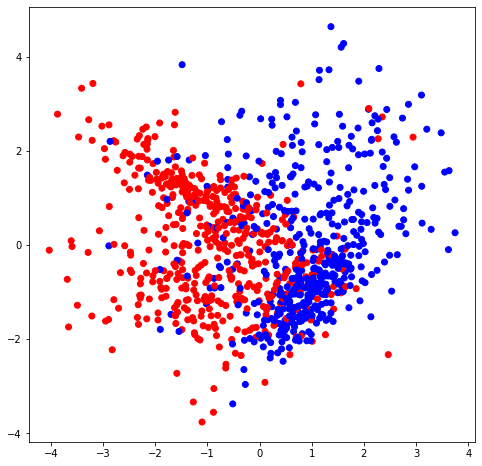

In [98]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [99]:
# Бутстрап
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    
    
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее min_leaf объекта
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

# формируем лес
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): 
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)
    
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [100]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [101]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [102]:
#Для визуализации
def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

кол-во деревьев: 1
Точность случайного леса из 1 деревьев на обучающей выборке: 90.429
Точность случайного леса из 1 деревьев на тестовой выборке: 68.667
кол-во деревьев: 3
Точность случайного леса из 3 деревьев на обучающей выборке: 95.714
Точность случайного леса из 3 деревьев на тестовой выборке: 77.000
кол-во деревьев: 5
Точность случайного леса из 5 деревьев на обучающей выборке: 98.714
Точность случайного леса из 5 деревьев на тестовой выборке: 80.333
кол-во деревьев: 10
Точность случайного леса из 10 деревьев на обучающей выборке: 98.429
Точность случайного леса из 10 деревьев на тестовой выборке: 78.667
кол-во деревьев: 50
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 79.000
кол-во деревьев: 100
Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 79.000
кол-во деревьев: 200
Точность случайного леса из 200 деревьев 

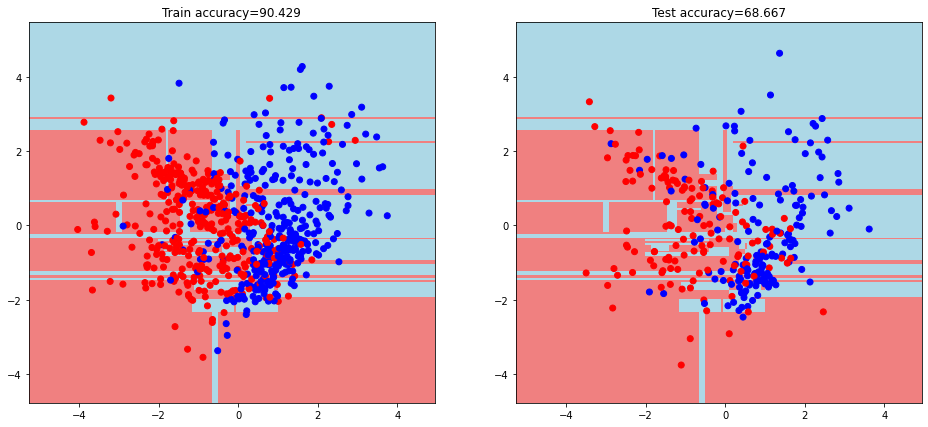

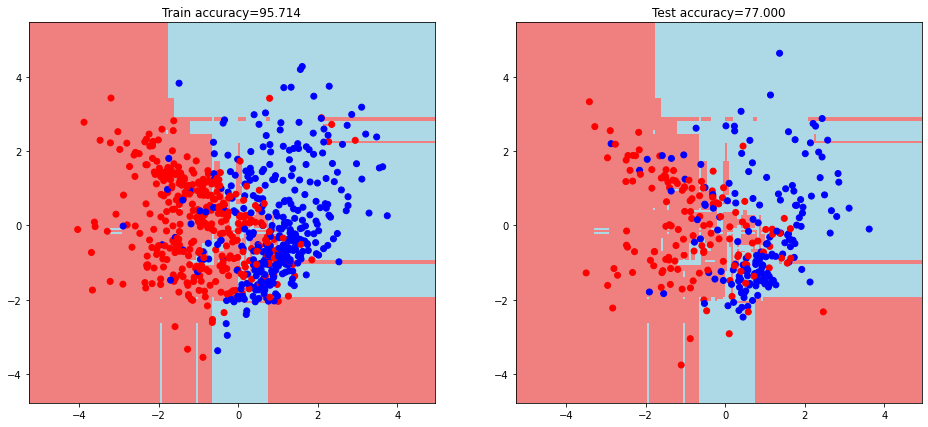

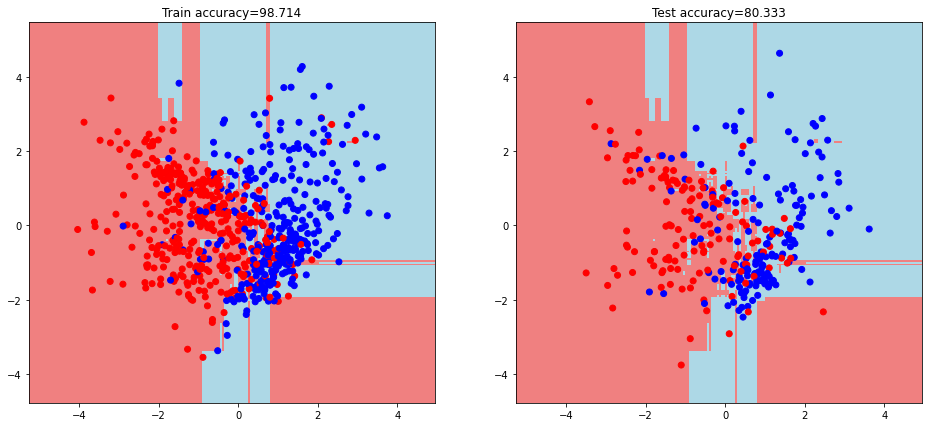

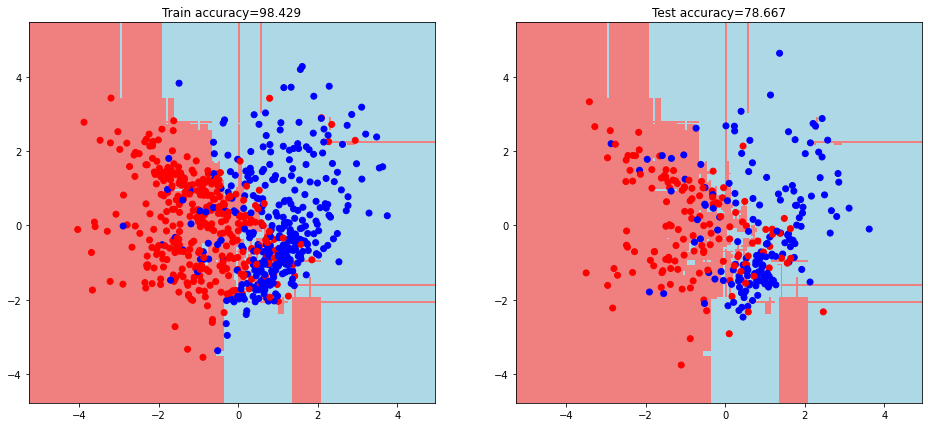

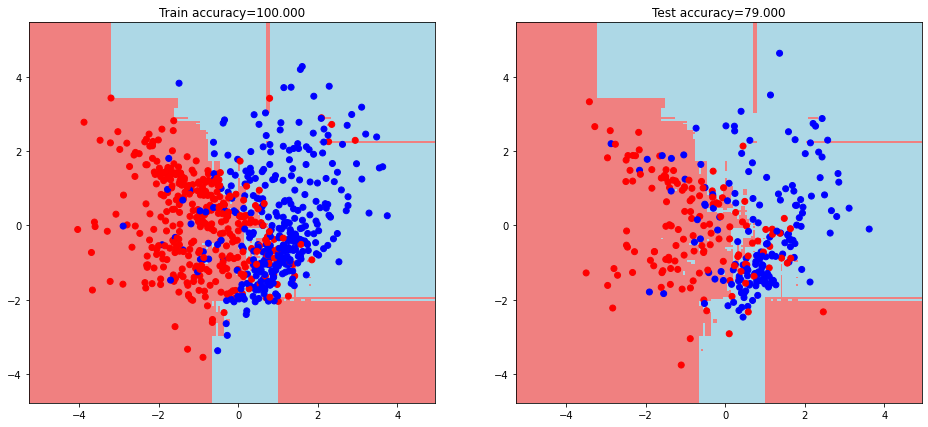

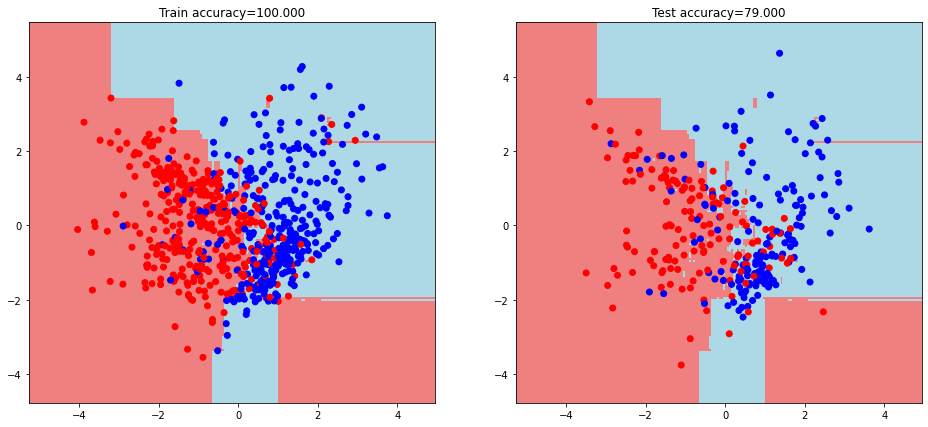

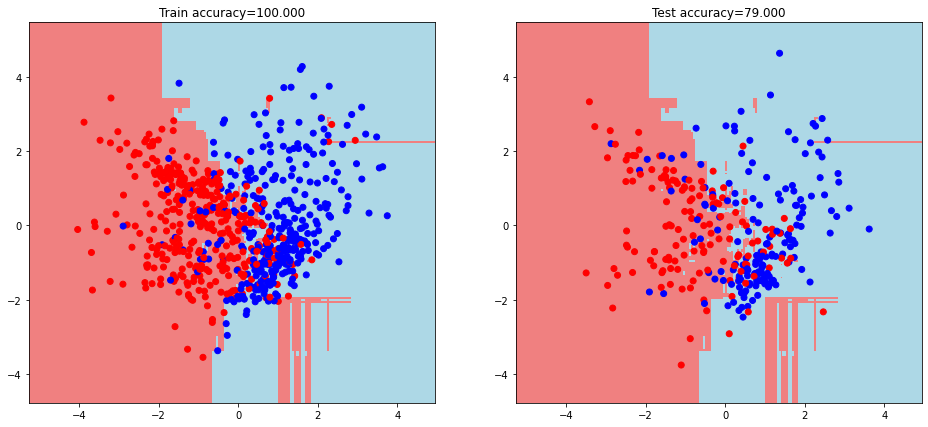

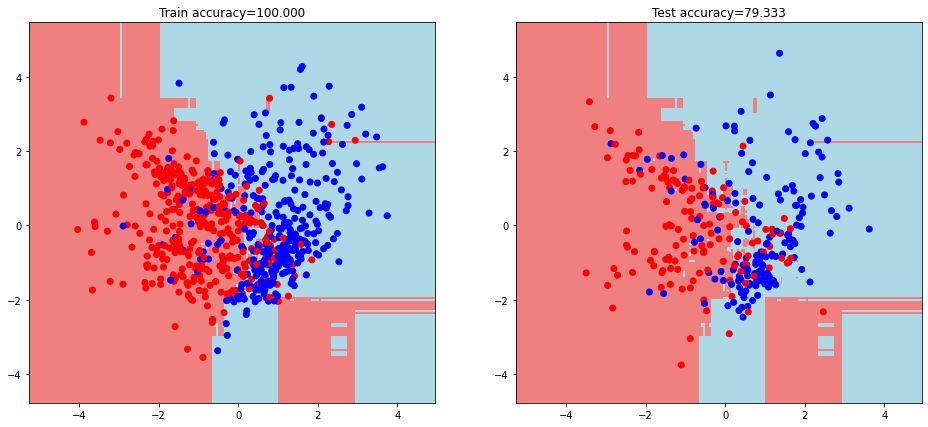

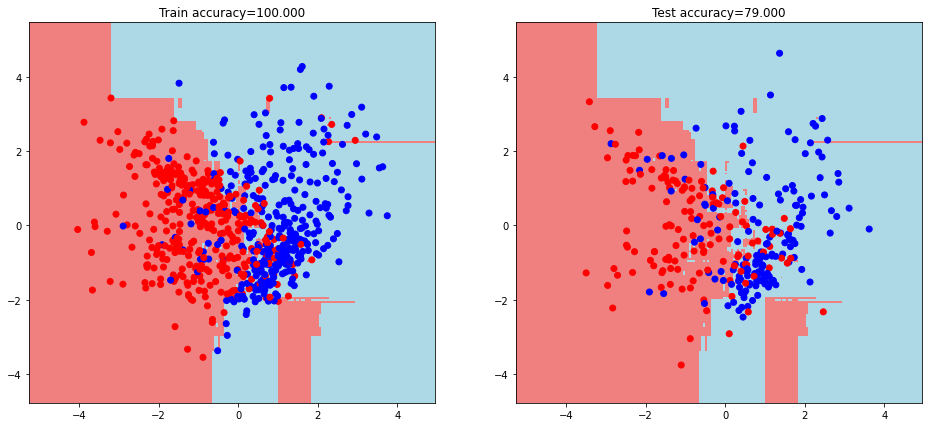

In [103]:
%%time
#строю лес
n_trees_ = [1, 3, 5, 10, 50, 100, 200, 500, 1000]

for n_ in n_trees_:
    n_trees = n_
    print(f'кол-во деревьев: {n_}')
    my_forest_1 = random_forest(train_data, train_labels, n_trees)

    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest_1, train_data)
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest_1, test_data)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    
#     # Визуализируем дерево на графике
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest_1, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.3f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.3f}')

Вывод: С увеличением кол-ва деревьев в ансамбле растет сложность гиперплоскости. Про недообучение мне тут сказать нечего - точность на трейне растет с увеличением количества деревьев, а вот переобучение, похоже, происходит ближе к 10 деревьям и дальше точность болтается ниже, чем у 5 деревьев.
Любопытное наблюдение: чем больше деревьев, тем чаще алгоритм делит плоскость там, где нет данных. кстати, я не понимаю, почему он вообще это делает. Это может быть признаком переобучения?

## Задание 2

In [108]:
# Бутстрап
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        b_index = set()
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            b_index.add(sample_index)  #Добавил индексы для оог проверки
        bootstrap.append((b_data, b_labels, b_index))
        
    return bootstrap


# формируем лес
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    forest_index = []  #Добавил индексы для ооб проверки
    
    for b_data, b_labels, b_index in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        forest_index.append(b_index) #!
        
    return forest, forest_index

# предсказание голосованием деревьев

def tree_vote(forest, data, forest_index, labels=None):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    vote_count = 0
    error_count = 0
    for index in range(len(data)):
        data_pred = []
        for index_ in range(len(forest_index)):
            if index in forest_index[index_]:
                continue
            data_pred.append(*predict([data[index_]], forest[index_]))
        if data_pred and labels is not None:
            if max(data_pred, key=data_pred.count) != labels[index]:
                error_count += 1
            vote_count += 1
    if vote_count != 0:
        oob = error_count/vote_count
    else:
        oob = error_count/1 
        
    return voted_predictions, oob

In [114]:
n_trees_ = [1, 3, 5, 10, 50, 100, 200]

for n_ in n_trees_:
    n_trees = n_
    my_forest_2, forest_index = random_forest(classification_data, classification_labels, n_trees)
    answers, oob = tree_vote(my_forest_2, classification_data, forest_index, classification_labels)
    accuracy = accuracy_metric(classification_labels, answers)
    print(f'кол-во деревьев: {n_} | accuracy: {accuracy:.2f} | Out of bag error: {oob:.2f}')

кол-во деревьев: 1 | accuracy: 91.10 | Out of bag error: 0.50
кол-во деревьев: 3 | accuracy: 95.00 | Out of bag error: 0.48
кол-во деревьев: 5 | accuracy: 96.80 | Out of bag error: 0.49
кол-во деревьев: 10 | accuracy: 98.30 | Out of bag error: 0.50
кол-во деревьев: 50 | accuracy: 99.80 | Out of bag error: 0.51
кол-во деревьев: 100 | accuracy: 100.00 | Out of bag error: 0.47
кол-во деревьев: 200 | accuracy: 100.00 | Out of bag error: 0.50


Получается, в половине случаев модель ошибается на объектах вне бутстрапа. Какой-то связи ооб с аккураси мне отсюда не видно.